## This note book gives the trend of multiple words in multiple mailing lists

What it does:
-it computes and plot word counts over time, on aggregated mailing lists' data.
-it exports emails that contains selected words 

Parameters to set options:
-it can track one or more words, according to the number of words set in the variable 'checkwords' 
-it can look in one or more mailing lists, according to how many urls are set; word counts are aggregated across mls
-it can look at literal words or at stemmed words, according to the 'stem' parameter

Useful extensions:
-export dictionary with wordcount trends on individual mailing lists
-look at compund words (e.g. 'human rights')
-give option to SUM word counts instead of treating words separately
-give possibility to normalize word counts

In [1]:
%matplotlib inline

In [3]:
from bigbang.archive import load as load_archive
from bigbang.archive import Archive
import bigbang.ingress.mailman as mailman
import bigbang.analysis.process as process
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
import pytz
import numpy as np
import math
import nltk
from itertools import repeat
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from nltk.corpus import stopwords
import re


In [4]:
#pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options

In [7]:
#insert a list of the urls of downloaded mailing lists that you want to include in the analysis. 
#data will be merged: multiple mailing lists are treated as a unique corpus


import os 
cwd = os.getcwd()    

archives_names = ["httpbisa"]


archives_paths = list()
for archive_name in archives_names:
    archives_paths.append('../../archives/'+archive_name+'.csv')
    

archives_list = [load_archive(archive_path).data for archive_path in archives_paths]
    
archives = Archive(pd.concat(archives_list))

archives_data = archives.data

In [8]:
#insert a list of *single* words to be tracked e.g. checkwords = ['rights', 'economy', 'human']
checkwords = ["protocol","middlebox","standard","chair"]

In [9]:
#to stem or not to stem? 
#if stem is set to True, then checkwords should be stemmed words (no plurals, no suffixes, etc.)
#if stem is set to False, then checkwords are searched for their literal spelling
stem = False

In [10]:
#The oldest date and more recent date for the whole mailing lists are displayed, so you WON't set an invalid time frame 
print(archives_data['Date'].min())
print(archives_data['Date'].max())

2002-04-12 16:28:21+00:00
2022-02-11 05:39:42+00:00


In [11]:
#you can filter the data by date range

#set the date frame
date_from = pd.datetime(1997,11,1,tzinfo=pytz.utc)
date_to = pd.datetime(2018,3,3,tzinfo=pytz.utc)

def filter_by_date(df,d_from,d_to):
    return df[(df['Date'] > d_from) & (df['Date'] < d_to)]

archives_data_filtered = filter_by_date(archives_data, date_from, date_to)

/home/gagarin/Data/anaconda3/envs/bigbang/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
/home/gagarin/Data/anaconda3/envs/bigbang/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [12]:
def count_word(text,word):
    if not text:
        return 0
    
    if len(word.split(" ")) <= 1:
        ## normalize the text - remove apostrophe and punctuation, lower case
        normalized_text = re.sub(r'[^\w]', ' ',text.replace("'","")).lower()
    
        tokenized_text = nltk.tokenize.word_tokenize(normalized_text)

        if stem:
            tokenized_text = [st.stem(t) for t in tokenized_text]
    
        return tokenized_text.count(word)
    else:
        return text.lower().count(word)

In [19]:
for word in checkwords:
    archives_data_filtered[word] = archives_data_filtered['Body'].apply(lambda x: count_word(x,word))

In [20]:
#save each email in a file based on which checkword it contains. good for doing some qualitative analysis

#set the path where the data are to be saved
path = '.'

import os

for word in checkwords:
    print("Saving data for checkword "+word+"...")
    archives_data_filtered[archives_data_filtered[word] > 0].to_csv(os.path.join(path,word+'.csv'))

Saving data for checkword protocol...
Saving data for checkword middlebox...
Saving data for checkword standard...
Saving data for checkword chair...


In [21]:
archives_data_filtered = archives_data_filtered.dropna(subset=['Date'])
archives_data_filtered['Date-ordinal'] = archives_data_filtered['Date'].apply(lambda x: x.toordinal())

archives_data_sums = archives_data_filtered.groupby('Date-ordinal').sum()


In [22]:
from datetime import date

for_export = archives_data_sums.copy()

dates_again = pd.Series(for_export.index,
                  index=for_export.index).apply(lambda x: 
                                                date.fromordinal(x))

for_export['Date'] = dates_again

for_export.to_csv("word_counts_by_date.csv")

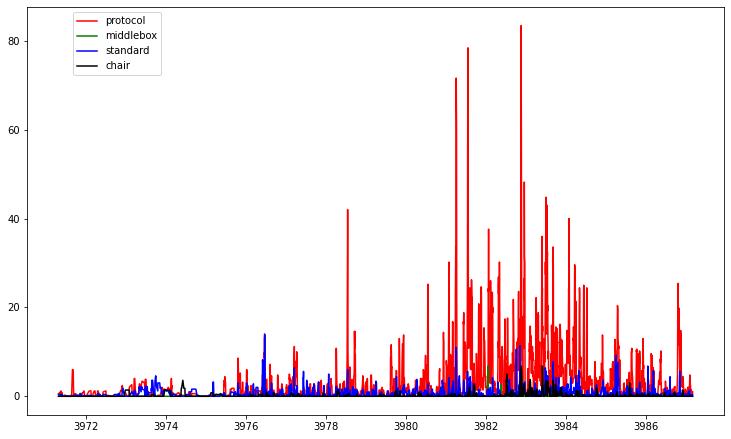

In [23]:
plt.figure(figsize=(12.5, 7.5))

colors = 'rgbkm'

window = 5

for i in range(len(checkwords)):
    smooth_sums = archives_data_sums.rolling(window).mean()
    
    plt.plot_date(smooth_sums.index,
                  smooth_sums[checkwords[i]],
                  colors[i],
                  label=checkwords[i])

plt.legend(bbox_to_anchor=(.2, 1))